In [ ]:
import numpy as np
import pandas as pd

# List of destinations
destinations = [
    ("Mumbai Dock", 18.9696, 72.8181),
    ("Amaravati, Andhra Pradesh", 16.5062, 80.6480),
    ("Itanagar, Arunachal Pradesh", 27.0844, 93.6053),
    ("Dispur, Assam", 26.1408, 91.7898),
    ("Patna, Bihar", 25.5941, 85.1376),
    ("Raipur, Chhattisgarh", 21.2514, 81.6296),
    ("Panaji, Goa", 15.4909, 73.8278),
    ("Gandhinagar, Gujarat", 23.2230, 72.6492),
    ("Chandigarh, Haryana", 30.7333, 76.7794),
    ("Shimla, Himachal Pradesh", 31.1048, 77.1734),
    ("Ranchi, Jharkhand", 23.3441, 85.3096),
    ("Bengaluru, Karnataka", 12.9716, 77.5946),
    ("Thiruvananthapuram, Kerala", 8.5241, 76.9366),
    ("Bhopal, Madhya Pradesh", 23.2599, 77.4126),
    ("Mumbai, Maharashtra", 19.0760, 72.8777),
    ("Imphal, Manipur", 24.8170, 93.9368),
    ("Shillong, Meghalaya", 25.5788, 91.8933),
    ("Aizawl, Mizoram", 23.1645, 92.9376),
    ("Kohima, Nagaland", 25.6701, 94.1077),
    ("Bhubaneswar, Odisha", 20.2961, 85.8245),
    ("Chandigarh, Punjab", 30.7333, 76.7794),
    ("Jaipur, Rajasthan", 26.9124, 75.7873),
    ("Gangtok, Sikkim", 27.3389, 88.6065),
    ("Chennai, Tamil Nadu", 13.0827, 80.2707),
    ("Hyderabad, Telangana", 17.3850, 78.4867),
    ("Agartala, Tripura", 23.8315, 91.2868),
    ("Lucknow, Uttar Pradesh", 26.8467, 80.9462),
    ("Dehradun, Uttarakhand", 30.3165, 78.0322),
    ("Kolkata, West Bengal", 22.5726, 88.3639),
    ("Port Blair, Andaman and Nicobar Islands", 11.6234, 92.7265),
    ("Silvassa, Dadra and Nagar Haveli", 20.2763, 73.0083),
    ("Delhi", 28.7041, 77.1025),
    ("Srinagar, Jammu and Kashmir", 34.0837, 74.7973),
    ("Leh, Ladakh", 34.1526, 77.5770),
    ("Kavaratti, Lakshadweep", 10.5667, 72.6369),
    ("Puducherry", 11.9139, 79.8145),
]

# Haversine formula to calculate distance
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

# Create the distance matrix
n = len(destinations)
distance_matrix = np.zeros((n, n))
for i in range(n):
    for j in range(n):
        if i != j:  # No need to calculate distance to itself
            lat1, lon1 = destinations[i][1], destinations[i][2]
            lat2, lon2 = destinations[j][1], destinations[j][2]
            distance_matrix[i][j] = haversine(lat1, lon1, lat2, lon2)

# Convert to DataFrame
city_names = [d[0] for d in destinations]
distance_df = pd.DataFrame(distance_matrix, index=city_names, columns=city_names)
print(distance_df)

# Save as CSV (optional)
distance_df.to_csv("distance_matrix.csv")
print("Distance matrix saved as 'distance_matrix.csv'")

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

class TSPEnvironment:
    def __init__(self, distance_matrix, city_names):
        self.distances = distance_matrix
        self.city_names = city_names
        self.num_cities = len(city_names)
        self.start_city = 0  # Mumbai Dock is always index 0

        # Normalize distances for more stable learning
        self.max_distance = np.max(distance_matrix)
        self.normalized_distances = distance_matrix / self.max_distance
        self.reset()

    def reset(self):
        self.current_city = self.start_city
        self.visited = [False] * self.num_cities
        self.visited[self.current_city] = True
        self.tour = [self.current_city]
        self.total_distance = 0
        self.need_return = False
        self.steps_taken = 0
        return self._get_state()

    def step(self, action):
        self.steps_taken += 1
        done = False

        if self.need_return:
            if action == self.start_city:
                distance = self.distances[self.current_city][self.start_city]
                normalized_distance = self.normalized_distances[self.current_city][self.start_city]
                self.total_distance += distance
                # Reward for completing tour successfully
                reward = -normalized_distance + 2.0
                self.tour.append(self.start_city)
                done = True
            else:
                reward = -10.0  # Stronger penalty for not returning to start
                done = True
        elif self.visited[action]:
            reward = -10.0  # Stronger penalty for revisiting
            done = True
        else:
            distance = self.distances[self.current_city][action]
            normalized_distance = self.normalized_distances[self.current_city][action]
            self.total_distance += distance

            # Base reward is negative normalized distance
            reward = -normalized_distance

            # Add progress reward for visiting new cities
            progress_reward = 0.1 * (sum(self.visited) / self.num_cities)
            reward += progress_reward

            self.visited[action] = True
            self.tour.append(action)
            self.current_city = action

            if all(self.visited):
                self.need_return = True
                reward += 1.0  # Bonus for visiting all cities

        # Add step penalty to encourage shorter paths
        reward -= 0.01 * self.steps_taken

        return self._get_state(), reward, done

    def _get_state(self):
        state = np.zeros(self.num_cities * 3 + 1)  # Enhanced state representation
        # Current city one-hot encoding
        state[self.current_city] = 1
        # Visited cities
        state[self.num_cities:2*self.num_cities] = self.visited
        # Distances from current city to all cities (normalized)
        state[2*self.num_cities:3*self.num_cities] = self.normalized_distances[self.current_city]
        # Return flag
        state[-1] = float(self.need_return)
        return state

class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorCritic, self).__init__()

        # Wider and deeper network
        self.shared = nn.Sequential(
            nn.Linear(state_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU()
        )

        # Separate actor and critic networks
        self.actor_hidden = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )

        self.critic_hidden = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, state):
        shared_features = self.shared(state)

        actor_hidden = self.actor_hidden(shared_features)
        actor_hidden = torch.clamp(actor_hidden, -20, 20)
        action_probs = nn.Softmax(dim=-1)(actor_hidden)

        value = self.critic_hidden(shared_features)
        return action_probs, value

class PPO:
    def __init__(self, state_dim, action_dim, lr=3e-5, gamma=0.99, epsilon=0.2, entropy_coef=0.01):
        self.actor_critic = ActorCritic(state_dim, action_dim)
        self.optimizer = optim.Adam(self.actor_critic.parameters(), lr=lr, weight_decay=1e-5)
        self.gamma = gamma
        self.epsilon = epsilon
        self.entropy_coef = entropy_coef

    def get_action(self, state, valid_actions=None):
        state = torch.FloatTensor(state)
        action_probs, _ = self.actor_critic(state)

        if valid_actions is not None:
            mask = torch.zeros_like(action_probs)
            mask[valid_actions] = 1
            action_probs = action_probs * mask
            action_probs = action_probs / (action_probs.sum() + 1e-10)

        dist = Categorical(action_probs)
        action = dist.sample()

        return action.item(), action_probs[action].item()

    def update(self, states, actions, old_probs, rewards, dones):
        states = np.array(states)
        actions = torch.LongTensor(actions)
        old_probs = torch.FloatTensor(old_probs)
        rewards = torch.FloatTensor(rewards)

        # Normalize rewards
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

        for _ in range(15):  # Increased number of epochs
            action_probs, values = self.actor_critic(states)
            values = values.squeeze()

            dist = Categorical(action_probs)
            new_probs = dist.log_prob(actions).exp()
            entropy = dist.entropy().mean()

            ratio = new_probs / (old_probs + 1e-10)

            returns = []
            R = 0
            for r, d in zip(reversed(rewards), reversed(dones)):
                R = r + self.gamma * R * (1-d)
                returns.insert(0, R)
            returns = torch.FloatTensor(returns)

            advantages = returns - values.detach()
            advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)

            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-self.epsilon, 1+self.epsilon) * advantages

            actor_loss = -torch.min(surr1, surr2).mean()
            critic_loss = 0.5 * (returns - values).pow(2).mean()
            entropy_loss = -self.entropy_coef * entropy

            loss = actor_loss + critic_loss + entropy_loss

            self.optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.actor_critic.parameters(), 0.5)
            self.optimizer.step()

def train_tsp_solver(distance_matrix, city_names, episodes=5000):
    env = TSPEnvironment(distance_matrix, city_names)
    state_dim = len(city_names) * 3 + 1  # Enhanced state space
    action_dim = len(city_names)

    ppo = PPO(state_dim, action_dim)
    best_distance = float('inf')
    best_tour = None
    no_improvement_count = 0

    print("Starting training with enhanced performance...")
    for episode in range(episodes):
        state = env.reset()
        states, actions, probs, rewards = [], [], [], []
        done = False

        while not done:
            if env.need_return:
                valid_actions = [env.start_city]
            else:
                valid_actions = [i for i, visited in enumerate(env.visited) if not visited]

            action, prob = ppo.get_action(state, valid_actions)
            next_state, reward, done = env.step(action)

            states.append(state)
            actions.append(action)
            probs.append(prob)
            rewards.append(reward)

            state = next_state

        if env.tour[-1] == env.start_city and env.total_distance < best_distance:
            best_distance = env.total_distance
            best_tour = [city_names[i] for i in env.tour]
            print(f"Episode {episode + 1}, New Best Distance: {best_distance:.2f}")
            no_improvement_count = 0
        else:
            no_improvement_count += 1

        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Current Best Distance: {best_distance:.2f}")

        ppo.update(states, actions, probs, rewards, [False]*(len(rewards)-1) + [True])

        # Early stopping if no improvement for a while
        if no_improvement_count >= 1000:
            print("Early stopping due to no improvement")
            break

    return best_tour, best_distance

def process_distance_matrix(csv_content):
    df = pd.read_csv(csv_content)
    city_names = df.columns[1:].tolist()
    distances = df.iloc[:, 1:].values
    return distances, city_names

In [ ]:
# Load your distance matrix
distances, city_names = process_distance_matrix('distance_matrix.csv')

# Train with more episodes if needed
best_tour, best_distance = train_tsp_solver(distances, city_names, episodes=5000)

print("\nBest tour found:")
print(" -> ".join(best_tour))
print(f"Total distance: {best_distance:.2f} km")

Starting training with enhanced performance...
Episode 1, New Best Distance: 45478.35


<ipython-input-1-6c0d8a9ac87d>:149: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  states = torch.FloatTensor(states)


Episode 5, New Best Distance: 44790.97
Episode 6, New Best Distance: 43961.10
Episode 28, New Best Distance: 41797.52
Episode 31, New Best Distance: 39570.01
Episode 100, Current Best Distance: 39570.01
Episode 200, Current Best Distance: 39570.01
Episode 265, New Best Distance: 37515.29
Episode 289, New Best Distance: 36395.83
Episode 300, Current Best Distance: 36395.83
Episode 400, Current Best Distance: 36395.83
Episode 500, Current Best Distance: 36395.83
Episode 587, New Best Distance: 35631.13
Episode 600, Current Best Distance: 35631.13
Episode 700, Current Best Distance: 35631.13
Episode 800, Current Best Distance: 35631.13
Episode 900, Current Best Distance: 35631.13
Episode 1000, Current Best Distance: 35631.13
Episode 1100, Current Best Distance: 35631.13
Episode 1200, Current Best Distance: 35631.13
Episode 1277, New Best Distance: 34086.62
Episode 1300, Current Best Distance: 34086.62
Episode 1342, New Best Distance: 33357.43
Episode 1365, New Best Distance: 29828.16
Epis

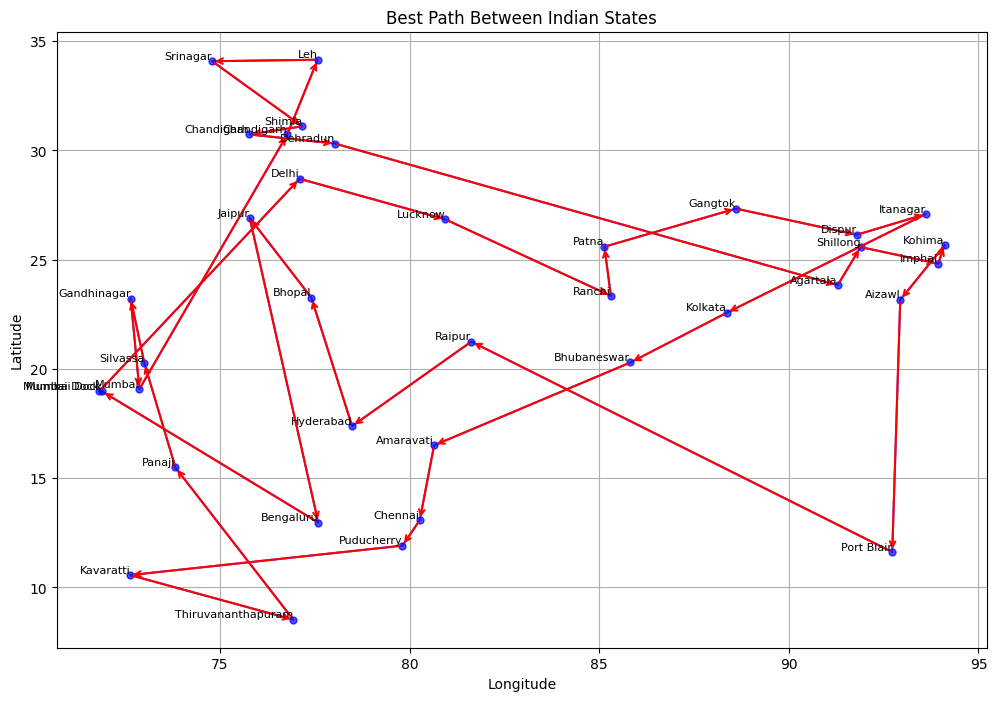

In [ ]:
import matplotlib.pyplot as plt

# Given best path explicitly from user
best_path = [
    ("Mumbai Dock", 18.9696, 71.8181),
    ("Delhi", 28.7041, 77.1025),
    ("Lucknow, Uttar Pradesh", 26.8467, 80.9462),
    ("Ranchi, Jharkhand", 23.3441, 85.3096),
    ("Patna, Bihar", 25.5941, 85.1376),
    ("Gangtok, Sikkim", 27.3389, 88.6065),
    ("Dispur, Assam", 26.1408, 91.7898),
    ("Itanagar, Arunachal Pradesh", 27.0844, 93.6053),
    ("Kolkata, West Bengal", 22.5726, 88.3639),
    ("Bhubaneswar, Odisha", 20.2961, 85.8245),
    ("Amaravati, Andhra Pradesh", 16.5062, 80.6480),
    ("Chennai, Tamil Nadu", 13.0827, 80.2707),
    ("Puducherry", 11.9139, 79.8145),
    ("Kavaratti, Lakshadweep", 10.5667, 72.6369),
    ("Thiruvananthapuram, Kerala", 8.5241, 76.9366),
    ("Panaji, Goa", 15.4909, 73.8278),
    ("Silvassa, Dadra and Nagar Haveli", 20.2763, 73.0083),
    ("Gandhinagar, Gujarat", 23.2230, 72.6492),
    ("Mumbai, Maharashtra", 19.0760, 72.8777),
    ("Chandigarh, Haryana", 30.7333, 76.7794),
    ("Leh, Ladakh", 34.1526, 77.5770),
    ("Srinagar, Jammu and Kashmir", 34.0837, 74.7973),
    ("Shimla, Himachal Pradesh", 31.1048, 77.1734),
    ("Chandigarh, Punjab", 30.7333, 75.7794),
    ("Dehradun, Uttarakhand", 30.3165, 78.0322),
    ("Agartala, Tripura", 23.8315, 91.2868),
    ("Shillong, Meghalaya", 25.5788, 91.8933),
    ("Imphal, Manipur", 24.8170, 93.9368),
    ("Kohima, Nagaland", 25.6701, 94.1077),
    ("Aizawl, Mizoram", 23.1645, 92.9376),
    ("Port Blair, Andaman and Nicobar Islands", 11.6234, 92.7265),
    ("Raipur, Chhattisgarh", 21.2514, 81.6296),
    ("Hyderabad, Telangana", 17.3850, 78.4867),
    ("Bhopal, Madhya Pradesh", 23.2599, 77.4126),
    ("Jaipur, Rajasthan", 26.9124, 75.7873),
    ("Bengaluru, Karnataka", 12.9716, 77.5946),
    ("Mumbai Dock", 18.9696, 71.8981),
]

# Extracting latitude and longitude
lats = [lat for _, lat, _ in best_path]
lons = [lon for _, _, lon in best_path]
labels = [name.split(',')[0] for name, _, _ in best_path]
# labs = [lab.split(',')[0] for lab in labels]

# Plot the route
plt.figure(figsize=(12, 8))
plt.plot(lons, lats, marker='o', linestyle='-', color='b', markersize=5, alpha=0.7)

# Add arrows for direction
for i in range(len(lons) - 1):
    plt.annotate('', xy=(lons[i + 1], lats[i + 1]), xytext=(lons[i], lats[i]),
                 arrowprops=dict(arrowstyle='->', color='r', lw=1.5))

# Annotate cities
for i, label in enumerate(labels):
    plt.text(lons[i], lats[i], label, fontsize=8, ha='right', va='bottom')

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Best Path Between Indian States")
plt.grid(True)

# Show plot
plt.show()


In [ ]:
print(labels)

['Mumbai Dock', 'Delhi', 'Lucknow', 'Ranchi', 'Patna', 'Gangtok', 'Dispur', 'Itanagar', 'Kolkata', 'Bhubaneswar', 'Amaravati', 'Chennai', 'Puducherry', 'Kavaratti', 'Thiruvananthapuram', 'Panaji', 'Silvassa', 'Gandhinagar', 'Mumbai', 'Chandigarh', 'Leh', 'Srinagar', 'Shimla', 'Chandigarh', 'Dehradun', 'Agartala', 'Shillong', 'Imphal', 'Kohima', 'Aizawl', 'Port Blair', 'Raipur', 'Hyderabad', 'Bhopal', 'Jaipur', 'Bengaluru', 'Mumbai Dock']


In [ ]:
# Best Route for the truck
best_route = [
    'Mumbai Dock', 'Delhi', 'Lucknow, Uttar Pradesh', 'Ranchi, Jharkhand', 'Patna, Bihar', 'Gangtok, Sikkim',
    'Dispur, Assam', 'Itanagar, Arunachal Pradesh', 'Kolkata, West Bengal', 'Bhubaneswar, Odisha',
    'Amaravati, Andhra Pradesh', 'Chennai, Tamil Nadu', 'Puducherry', 'Kavaratti, Lakshadweep',
    'Thiruvananthapuram, Kerala', 'Panaji, Goa', 'Silvassa, Dadra and Nagar Haveli', 'Gandhinagar, Gujarat',
    'Mumbai, Maharashtra', 'Chandigarh, Haryana', 'Leh, Ladakh', 'Srinagar, Jammu and Kashmir',
    'Shimla, Himachal Pradesh', 'Chandigarh, Punjab', 'Dehradun, Uttarakhand', 'Agartala, Tripura',
    'Shillong, Meghalaya', 'Imphal, Manipur', 'Kohima, Nagaland', 'Aizawl, Mizoram',
    'Port Blair, Andaman and Nicobar Islands', 'Raipur, Chhattisgarh', 'Hyderabad, Telangana',
    'Bhopal, Madhya Pradesh', 'Jaipur, Rajasthan', 'Bengaluru, Karnataka', 'Mumbai Dock'
]

# Products required at each location
shipment_allocation = {
    'Amaravati, Andhra Pradesh': 'Traditional sarees and ethnic wear',
    'Itanagar, Arunachal Pradesh': 'Winter essentials',
    'Dispur, Assam': 'Lightweight cotton clothing',
    'Patna, Bihar': 'Formal office wear',
    'Raipur, Chhattisgarh': 'Casual clothing',
    'Panaji, Goa': 'Summer and beachwear',
    'Gandhinagar, Gujarat': 'Festive wear',
    'Chandigarh, Haryana': 'Activewear',
    'Shimla, Himachal Pradesh': 'Heavy-duty winter gear',
    'Ranchi, Jharkhand': 'Everyday casual clothing',
    'Bengaluru, Karnataka': 'Trendy urban fashion',
    'Thiruvananthapuram, Kerala': 'Cotton and linen wear',
    'Bhopal, Madhya Pradesh': 'Multi-purpose clothing',
    'Mumbai Dock': 'Central warehouse and dispatch hub',
    'Imphal, Manipur': 'Traditional handwoven garments',
    'Shillong, Meghalaya': 'Rain-resistant apparel',
    'Aizawl, Mizoram': 'Ceremonial and cultural attire',
    'Kohima, Nagaland': 'Accessories like caps and scarves',
    'Bhubaneswar, Odisha': 'Ethnic and casual wear',
    'Chandigarh, Punjab': 'Thermal wear',
    'Jaipur, Rajasthan': 'Designer lehengas and sarees',
    'Gangtok, Sikkim': 'Hiking and trekking gear',
    'Chennai, Tamil Nadu': 'Light cotton wear',
    'Hyderabad, Telangana': 'Modern fashion',
    'Agartala, Tripura': 'Handloom sarees',
    'Lucknow, Uttar Pradesh': 'Chikankari embroidery wear',
    'Dehradun, Uttarakhand': 'Outdoor and trekking apparel',
    'Kolkata, West Bengal': 'Festive sarees',
    'Port Blair, Andaman and Nicobar Islands': 'Light beachwear',
    'Delhi': 'Modern urban fashion',
    'Srinagar, Jammu and Kashmir': 'Thermal wear and woolen clothing',
    'Leh, Ladakh': 'Adventure gear',
    'Kavaratti, Lakshadweep': 'Light cotton wear',
    'Puducherry': 'Relaxed summer clothing'
}

In [ ]:
# Create a list of dictionaries for DataFrame creation
shipment_data = []
for location in best_route:
    product = shipment_allocation.get(location, "No specific product assigned")
    shipment_data.append({"Location": location, "Product": product})

# Create the pandas DataFrame
shipment_df = pd.DataFrame(shipment_data)
shipment_df

,Location,Product
0,Mumbai Dock,Central warehouse and dispatch hub
1,Delhi,Modern urban fashion
2,"Lucknow, Uttar Pradesh",Chikankari embroidery wear
3,"Ranchi, Jharkhand",Everyday casual clothing
4,"Patna, Bihar",Formal office wear
5,"Gangtok, Sikkim",Hiking and trekking gear
6,"Dispur, Assam",Lightweight cotton clothing
7,"Itanagar, Arunachal Pradesh",Winter essentials
8,"Kolkata, West Bengal",Festive sarees
9,"Bhubaneswar, Odisha",Ethnic and casual wear


In [ ]:
# Generate loading order (reverse order of delivery)
loading_order = list(reversed(best_route[1:-1]))

# Display Loading Order
print("\nLoading Order (Last to be delivered is loaded first):\n")
for location in loading_order:
    product = shipment_allocation.get(location, "No specific product assigned")
    print(f"📦 Load: {product} for {location}")



Shipment Allocation Plan:

Mumbai Dock:-> Central warehouse and dispatch hub
Delhi:-> Modern urban fashion
Lucknow, Uttar Pradesh:-> Chikankari embroidery wear
Ranchi, Jharkhand:-> Everyday casual clothing
Patna, Bihar:-> Formal office wear
Gangtok, Sikkim:-> Hiking and trekking gear
Dispur, Assam:-> Lightweight cotton clothing
Itanagar, Arunachal Pradesh:-> Winter essentials
Kolkata, West Bengal:-> Festive sarees
Bhubaneswar, Odisha:-> Ethnic and casual wear
Amaravati, Andhra Pradesh:-> Traditional sarees and ethnic wear
Chennai, Tamil Nadu:-> Light cotton wear
Puducherry:-> Relaxed summer clothing
Kavaratti, Lakshadweep:-> Light cotton wear
Thiruvananthapuram, Kerala:-> Cotton and linen wear
Panaji, Goa:-> Summer and beachwear
Silvassa, Dadra and Nagar Haveli:-> No specific product assigned
Gandhinagar, Gujarat:-> Festive wear
Mumbai, Maharashtra:-> No specific product assigned
Chandigarh, Haryana:-> Activewear
Leh, Ladakh:-> Adventure gear
Srinagar, Jammu and Kashmir:-> Thermal wea

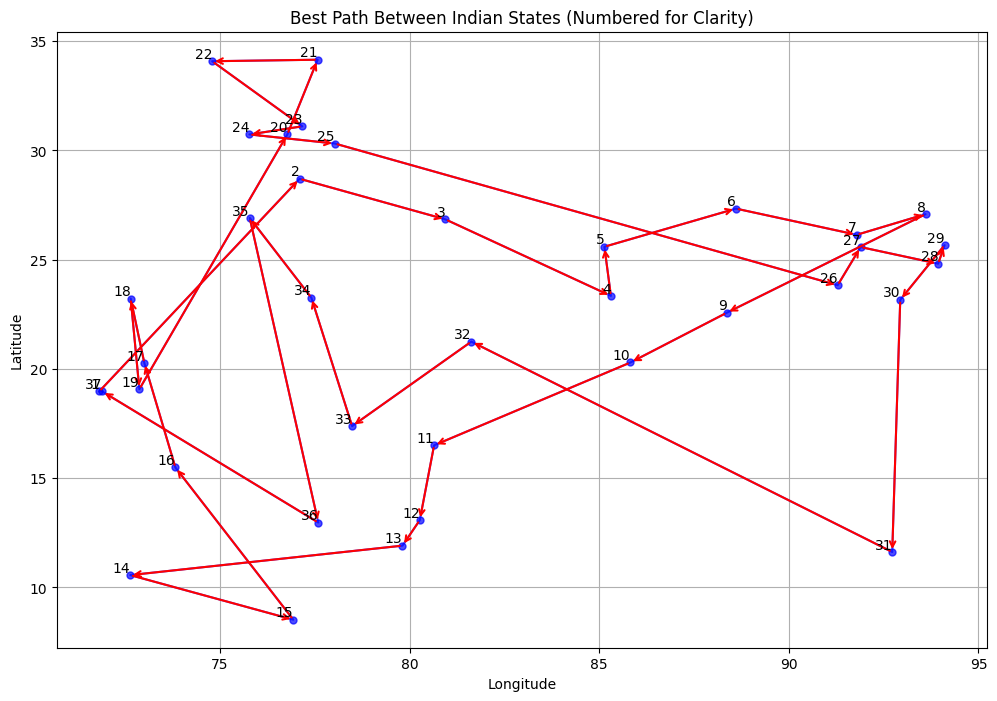

1. Mumbai Dock
2. Delhi
3. Lucknow, Uttar Pradesh
4. Ranchi, Jharkhand
5. Patna, Bihar
6. Gangtok, Sikkim
7. Dispur, Assam
8. Itanagar, Arunachal Pradesh
9. Kolkata, West Bengal
10. Bhubaneswar, Odisha
11. Amaravati, Andhra Pradesh
12. Chennai, Tamil Nadu
13. Puducherry
14. Kavaratti, Lakshadweep
15. Thiruvananthapuram, Kerala
16. Panaji, Goa
17. Silvassa, Dadra and Nagar Haveli
18. Gandhinagar, Gujarat
19. Mumbai, Maharashtra
20. Chandigarh, Haryana
21. Leh, Ladakh
22. Srinagar, Jammu and Kashmir
23. Shimla, Himachal Pradesh
24. Chandigarh, Punjab
25. Dehradun, Uttarakhand
26. Agartala, Tripura
27. Shillong, Meghalaya
28. Imphal, Manipur
29. Kohima, Nagaland
30. Aizawl, Mizoram
31. Port Blair, Andaman and Nicobar Islands
32. Raipur, Chhattisgarh
33. Hyderabad, Telangana
34. Bhopal, Madhya Pradesh
35. Jaipur, Rajasthan
36. Bengaluru, Karnataka
37. Mumbai Dock


In [ ]:
import matplotlib.pyplot as plt

# Given best path explicitly from user
best_path = [
    ("Mumbai Dock", 18.9696, 71.8181),
    ("Delhi", 28.7041, 77.1025),
    ("Lucknow, Uttar Pradesh", 26.8467, 80.9462),
    ("Ranchi, Jharkhand", 23.3441, 85.3096),
    ("Patna, Bihar", 25.5941, 85.1376),
    ("Gangtok, Sikkim", 27.3389, 88.6065),
    ("Dispur, Assam", 26.1408, 91.7898),
    ("Itanagar, Arunachal Pradesh", 27.0844, 93.6053),
    ("Kolkata, West Bengal", 22.5726, 88.3639),
    ("Bhubaneswar, Odisha", 20.2961, 85.8245),
    ("Amaravati, Andhra Pradesh", 16.5062, 80.6480),
    ("Chennai, Tamil Nadu", 13.0827, 80.2707),
    ("Puducherry", 11.9139, 79.8145),
    ("Kavaratti, Lakshadweep", 10.5667, 72.6369),
    ("Thiruvananthapuram, Kerala", 8.5241, 76.9366),
    ("Panaji, Goa", 15.4909, 73.8278),
    ("Silvassa, Dadra and Nagar Haveli", 20.2763, 73.0083),
    ("Gandhinagar, Gujarat", 23.2230, 72.6492),
    ("Mumbai, Maharashtra", 19.0760, 72.8777),
    ("Chandigarh, Haryana", 30.7333, 76.7794),
    ("Leh, Ladakh", 34.1526, 77.5770),
    ("Srinagar, Jammu and Kashmir", 34.0837, 74.7973),
    ("Shimla, Himachal Pradesh", 31.1048, 77.1734),
    ("Chandigarh, Punjab", 30.7333, 75.7794),
    ("Dehradun, Uttarakhand", 30.3165, 78.0322),
    ("Agartala, Tripura", 23.8315, 91.2868),
    ("Shillong, Meghalaya", 25.5788, 91.8933),
    ("Imphal, Manipur", 24.8170, 93.9368),
    ("Kohima, Nagaland", 25.6701, 94.1077),
    ("Aizawl, Mizoram", 23.1645, 92.9376),
    ("Port Blair, Andaman and Nicobar Islands", 11.6234, 92.7265),
    ("Raipur, Chhattisgarh", 21.2514, 81.6296),
    ("Hyderabad, Telangana", 17.3850, 78.4867),
    ("Bhopal, Madhya Pradesh", 23.2599, 77.4126),
    ("Jaipur, Rajasthan", 26.9124, 75.7873),
    ("Bengaluru, Karnataka", 12.9716, 77.5946),
    ("Mumbai Dock", 18.9696, 71.8981),
]

# Extract latitude and longitude
lats = [lat for _, lat, _ in best_path]
lons = [lon for _, _, lon in best_path]

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(lons, lats, marker='o', linestyle='-', color='b', markersize=5, alpha=0.7)

# Add arrows for direction
for i in range(len(lons) - 1):
    plt.annotate('', xy=(lons[i + 1], lats[i + 1]), xytext=(lons[i], lats[i]),
                 arrowprops=dict(arrowstyle='->', color='r', lw=1.5))

# Annotate locations with numbers
for i in range(len(best_path)):
    plt.text(lons[i], lats[i], str(i+1), fontsize=10, ha='right', va='bottom', color='black')

# Labels and title
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Best Path Between Indian States (Numbered for Clarity)")
plt.grid(True)

# Show plot
plt.show()

# Print numbered path for reference
for i, (name, _, _) in enumerate(best_path):
    print(f"{i+1}. {name}")
